<img class="gb_ua" src="https://www.gstatic.com/android/market_images/web/play_prism_hlock_2x.png" alt="" aria-hidden="true" style="width:549px;height:117px" data-atf="true">

<p style="background-color:White;">The Android World is full of apps.People have different choices and different necessities.The creator of the app also have financial goals, they have to price them  in such a way that they can earn maximum revenue.</p>

<p style="background-color:White;">The data on apps web scrapped from the play store is studied here.Some of the apps are free, while the others are priced.The priced apps are our subject of study.</p>


For our analysis, first we import the requisite libraries.

<h1 style="text-align:center;font-size:100%;;">The Libraries</h1>

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 9,7

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots


<h1 style="text-align:center;font-size:100%;;">Glimpse of the data</h1>

First we have an initial look at the data structure.

In [113]:
apps = pd.read_csv("./googleplaystore.csv", dtype={'Rating': np.float32})
print("Total number of rows is",len(apps))
apps.head(2)


Total number of rows is 10841


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up


Let us check and clean the data in case there are some inappropriate or absurd entries.

<h1 style="text-align:center;font-size:100%;;">Unique items in each categorical variable</h1>

For the categorical variables, let us find out the the count of apps, categories, type of the app(Free or paid), content rating  and the Genres 

In [114]:
apps[['App','Category','Type','Content Rating','Genres']].nunique()

App               9660
Category            34
Type                 3
Content Rating       6
Genres             120
dtype: int64

<h1 style="text-align:center;font-size:100%;;">The type column</h1>

<p style="background-color:White;"> Interestingly, we find that the Type column has 3 unique categories. However, only two- Free and Paid are possible. Let us find out the third category and the number of occurrences.</p>

In [115]:
apps['Type'].value_counts()

Free    10039
Paid      800
0           1
Name: Type, dtype: int64

**<font color='Red'> Finding: </font>**

There is a third category- 0 among the Paid and Free apps and it occurred only once. Let us see the corresponding record.



In [116]:
apps[apps['Type']== '0']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


**<font color='Red'> Finding: </font>**

From observation we find that the values of the columns just got shifted one place right. Lets fix it.

In [117]:
apps.loc[10472,"App"] = "Life Made WI-Fi"
apps.loc[10472,"Category"] = "Touchscreen Photo Frame"
apps.loc[10472,"Rating"] = "1.9"
apps.loc[10472,"Reviews"] = 19
apps.loc[10472,"Size"] = "3.0M"
apps.loc[10472,"Installs"] = "1,000+"
apps.loc[10472,"Type"] = "Free"
apps.loc[10472,"Price"] = "0"
apps.loc[10472,"Content Rating"] = "Everyone"
apps.loc[10472,"Genres"] = "NaN"
apps.loc[10472,"Last Updated"] = "February 11,2018"
apps.loc[10472,"Current Ver"] = "1.0.19"
apps.loc[10472,"Android Ver"] = "4.0 and up"
apps[apps['App'] == "Life Made WI-Fi"]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi,Touchscreen Photo Frame,1.9,19,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11,2018",1.0.19,4.0 and up


<h1 style="text-align:Center;font-size:100%;;">Apps appearing more than once</h1>

Now let us check whether we have any duplicate rows, that is any app that has been web-scrapped more than once. 

We will identify duplicate apps by checking on all the categorical columns with identical information.If two or more record have identical informations with respect to all the selected columns ('App', 'Category', 'Size', 'Type','Price','Content Rating', 'Genres','Last Updated', 'Current Ver', 'Android Ver'])-- only one will be kept and the rest will be deleted. We have not considered some numerical columns (like rating, review, Installs), since the data is web scrapped, and duplications occur if a particular app is scrapped more than once and within that interval, these informations may have changed.

<h1 style="text-align:Center;font-size:100%;;">Retaining unique instance of each app</h1>


In [118]:
# making a bool series of all duplicates
bool_series = apps.duplicated(subset = ['App', 'Category', 'Size', 'Type','Price','Content Rating', 'Genres','Last Updated', 'Current Ver', 'Android Ver']) 

#subset the unique ones
unique_apps = apps[~bool_series]

print("The number of unique apps --- ", len(unique_apps))



The number of unique apps ---  9780


Out of 10840 records, 1060 records have been deleted as duplicate.

<h1 style="text-align:Center;font-size:100%;;">Formatting the data</h1>

So we have detected and retained only one instance of each app in the data.We are left with 9660 unique apps. Now we are in a position to format the data for further analysis.


Now let us consider the numerical variables and check the format of each of them. In case we find that a quantitative variable has some textual element in its entries, then we need to make them completely numerical, for mathematical calculations.

Let us start with size of the app.

# Size

In [119]:
unique_apps['Size'].value_counts()

Varies with device    1267
11M                    183
12M                    182
13M                    179
14M                    178
                      ... 
269k                     1
500k                     1
122k                     1
609k                     1
608k                     1
Name: Size, Length: 461, dtype: int64

The apps are of various sizes, some are in KB while some are in MB.We convert all MBs in KBs by multiplying them by 1024.

We also find that there are a lot of apps which have "Varies With Device" as App size. We require to have an approximate numerical estimate for those apps as our aim is to retain maximum data for analysis. In that goal, we group the data, Category wise and fill up 
the missing sizes of the app using the median size of same Category. (For example, if the app under question happens to be a Gaming App, then its size will be approximated by the median size of other Gaming Apps.)

In [120]:
#conversion in KB (AS a common unit)

def conversion(dfcol):
    if 'M' in str(dfcol):
        return float(str(dfcol).replace('M', ''))*1000
    elif 'k' in str(dfcol):
        return float(str(dfcol).replace('k', ''))
    elif 'Varies with device' in dfcol:
        return np.nan
    else:
        return dfcol
    
unique_apps['Size'] = unique_apps['Size'].apply(conversion)
unique_apps['Size'] = unique_apps['Size'].astype(float)


unique_apps['Size']= unique_apps['Size'].fillna(unique_apps.groupby('Category')['Size'].transform('median'))

# Installs

Now we have a look at the data on Installs.

In [121]:
unique_apps['Installs'].value_counts()

1,000,000+        1433
100,000+          1116
10,000+           1032
10,000,000+        972
1,000+             891
100+               710
5,000,000+         623
500,000+           510
50,000+            469
5,000+             468
10+                385
500+               328
50,000,000+        214
100,000,000+       209
50+                204
5+                  82
1+                  67
500,000,000+        29
1,000,000,000+      23
0+                  14
0                    1
Name: Installs, dtype: int64

The installs column has "+" and "," which we require to get rid of, so that the column can be used for numerical analysis.

In [122]:
unique_apps['Installs'] = unique_apps['Installs'].str.replace('+','')
unique_apps['Installs'] = unique_apps['Installs'].str.replace(',','')
unique_apps['Installs']= unique_apps['Installs'].astype(float)


# Price

In [123]:
unique_apps['Price'].value_counts()

0         9022
$0.99      145
$2.99      124
$1.99       73
$4.99       70
          ... 
$1.75        1
$2.59        1
$3.08        1
$79.99       1
$4.80        1
Name: Price, Length: 92, dtype: int64

The Price column has "$" which we require to get rid of, so that the column can be used for numerical analysis.

In [124]:
unique_apps['Price'] = unique_apps['Price'].str.replace('$','')

unique_apps['Price'] = unique_apps['Price'].astype(float)

# Rating and Review

We have casted "Rating" and "Review" variable in float, for any future numerical analysis.

In [125]:
unique_apps['Rating'] = unique_apps['Rating'].astype(float)
unique_apps['Reviews'] = unique_apps['Reviews'].astype(float)

<h1 style="text-align:Center;font-size:100%;;">Number of Missing Values</h1>

Following is the summary report on missing value that we observed. 

Note that there are many values missing for 'Rating' Variable. Some apps may not have rating data at the time of web-scrapping, we can not do anything and let us keep it as it is. 

Also there are few cases where the Current Version and the Android Version is missing,this is also not an important information in the light of our present study, so again it is kept as is.



In [126]:
total_missing = unique_apps.isnull().sum().sort_values()
print(total_missing)
print(unique_apps.shape , "---- Final shape of the Data")
len(unique_apps)

App                  0
Category             0
Reviews              0
Size                 0
Installs             0
Price                0
Content Rating       0
Genres               0
Last Updated         0
Type                 1
Android Ver          2
Current Ver          8
Rating            1465
dtype: int64
(9780, 13) ---- Final shape of the Data


9780

This is our final cleaned data, with 9780 rows and 13 columns.

All that are missing will not be required in our present analysis. We have retained those to avoid loss of information.

<h1 style="text-align:Center;font-size:100%;;">Copy of the cleaned data </h1>

Let us make a copy of the cleaned data which is to be used for analysis.

In [127]:
df = unique_apps.copy()

# Analysis on cleaned data
<h1 style="text-align:center;font-size:100%;;">Categories</h1>

First we determine the number of unique categories of Apps present in our dataset.

In [128]:
print("There are" , len(df['Category'].value_counts()), "Different Categories.")


There are 34 Different Categories.


We will merge the categories which has less than 1% of app representation, so that the result does not get skewed by categories which have very few apps.

In [129]:
cat_pc = df['Category'].value_counts()/df['Category'].value_counts().sum()
type(cat_pc)
arr = []
for index in cat_pc.index:
    if cat_pc[index] < 0.01:
        arr.append(index)
df['category_clubbed'] = np.where(df["Category"].isin(arr), "OTHERS", df['Category'])
print("There are" , len(df['category_clubbed'].value_counts()), "Different Categories after merging.")

There are 25 Different Categories after merging.


Therefore, after merging the  category which have very few app representation, we get 25 major App Categories

<h1 style="text-align:center;font-size:100%;;">Most Downloaded Categories</h1>

Let us see the Category of the apps which are most downloaded and which are least downloaded.

In [130]:
print("\n", 'The most popular categories are as follows:')
df_top_cat = df[['category_clubbed','Installs']].groupby(['category_clubbed'], as_index = False).sum().sort_values(['Installs'], ascending = False).head(10)
df_top_cat


 The most popular categories are as follows:


,category_clubbed,Installs
9,GAME,1.399392e+10
2,COMMUNICATION,1.103928e+10
6,FAMILY,8.995643e+09
22,TOOLS,8.122772e+09
18,PRODUCTIVITY,6.803091e+09
17,PHOTOGRAPHY,5.769148e+09
20,SOCIAL,5.497868e+09
24,VIDEO_PLAYERS,4.432003e+09
23,TRAVEL_AND_LOCAL,2.894887e+09
14,NEWS_AND_MAGAZINES,2.879218e+09


Game, Communication, Family Apps fall under the most downloaded categories.

Now Let us find out the categories which has very less app Downloads.


In [131]:
df[['category_clubbed','Installs']].groupby(['category_clubbed'], as_index = False).sum().sort_values(['Installs'], ascending = True).head(5)


,category_clubbed,Installs
13,MEDICAL,40304177.0
3,DATING,150926107.0
8,FOOD_AND_DRINK,212798751.0
4,EDUCATION,352952000.0
7,FINANCE,460348734.0


The Medical, Dating and Food and Drink Category are the Categories which has least downloads.

Now we plot the whole 25 major app categories in order of downloads, to get a holistic picture of the dataset

In [132]:
df_for_category_plot = df[['category_clubbed', 'Installs']].groupby(['category_clubbed'], as_index=False).sum().sort_values(by = 'Installs', ascending = False)

trace1 = go.Bar(
    x=df_for_category_plot['category_clubbed'],  
    y=df_for_category_plot['Installs']
   
)
data =[trace1]
layout = go.Layout(title = "Installs for each Category")
fig = go.Figure(data = data, layout = layout)
fig.show()

<h1 style="text-align:center;font-size:100%;;">Rating --How is rating distributed over all Apps?</h1>



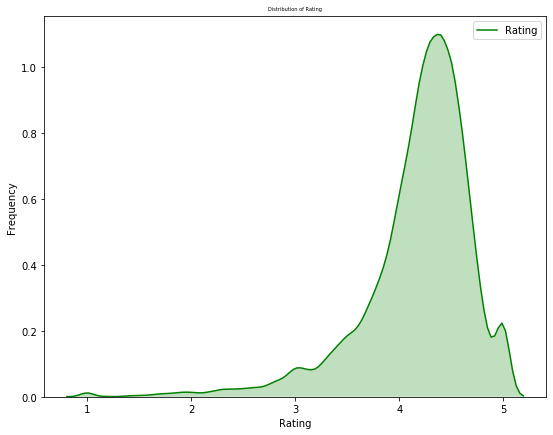

In [133]:
g = sns.kdeplot(df['Rating'], color="green", shade = True)
g.set_xlabel("Rating")
g.set_ylabel("Frequency")
plt.title('Distribution of Rating',size = 5)
plt.show()

**<font color='Red'> Finding: </font>**


On an average, the rating for Google play Store apps is on the higher side- infact around 4.0.
Good News App Developers!

<h1 style="text-align:center;font-size:100%;;">Popular Content Rating </h1>

In [134]:
print(df['Content Rating'].value_counts().head(10))
print("There are" , len(df['Content Rating'].value_counts()), "types of Content Rating.")


Everyone           7980
Teen               1063
Mature 17+          396
Everyone 10+        336
Adults only 18+       3
Unrated               2
Name: Content Rating, dtype: int64
There are 6 types of Content Rating.


**<font color='Red'> Finding: </font>**

The Most popular Content Ratings are Everyone and teen, i.e most apps are released for all age groups or specifically for teens. On the other hand, the App developers are either rarely creating any app specifically for adults (we found only 3) or the app developers are not tagging them as adults only.

<h1 style="text-align:center;font-size:100%;;">Analysis of the Paid Apps</h1>

Now for the paid apps, we are going to find out the relation of valuation of the apps with respect to the number of downloads ie which one the consumers prefer to download.

For our study we create a separate dataframe for the paid apps only.

In [135]:
only_paid = df[df['Price'] > 0]

First we takeup the statistical analysis of the paid apps, so we calculate the summary statistics of the same, which is as follows:

In [136]:
print(df.loc[(df['Price'] > 0),'Price'].describe())

count    758.000000
mean      14.021253
std       58.667827
min        0.990000
25%        1.490000
50%        2.990000
75%        4.990000
max      400.000000
Name: Price, dtype: float64


There are 758 paid apps, the mean price of paid apps is 14.021 Dollars. The first quartile is 1.49 which implies 25% of the apps is priced below 1.49 Dollars, while half of the paid apps are priced 2.99 Dollar and below.
75% of the paid apps are priced below 4.99 Dollars. However the maximum price of the app is seen to be 400 Dollars which is quite high with respect to the rest.

So we made another analysis, this time taking only the last quartile, to understand the distrubtion of price in the quarter.
The following code shows this.


In [137]:
print(df.loc[(df['Price'] > 4.99), 'Price'].describe())

count    161.000000
mean      56.436335
std      118.233919
min        5.000000
25%        6.990000
50%        9.990000
75%       19.990000
max      400.000000
Name: Price, dtype: float64


In the last quartile, that is among the apps that are priced more than 4.99 Dollars, the mean price is 56 Dollars while the median value is 9.99 Dollars, which implies there are few expensive apps that are swaying the mean to a large value.
Here the first quartile is 6.99 Dollars (that is 25% of the apps which are priced more than 4.99 Dollars are priced below 6.99 Dollars, while 75% of the apps are priced below 19.99 Dollars.

The standard deviation is quite high at 118.23, which implies that the data is very much scattered for the apps valued above 5 Dollars. 


Now to get a better idea of data structure,we plot some stripplot graphs and try to understand the inherent structure of the whole data on priced apps.

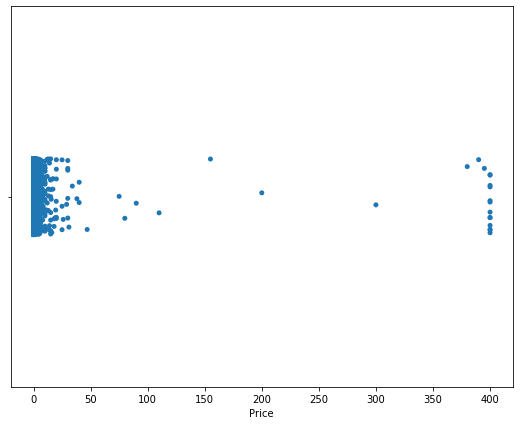

In [138]:
sns.stripplot(data=df, x="Price")


From the graph, it is obvious that the data is highly scattered, with most apps being priced within 50 Dollars or less, and few others are at the highest end.
Let us zoom in and try to find out the distribution of apps that are priced  50 dollars or less 

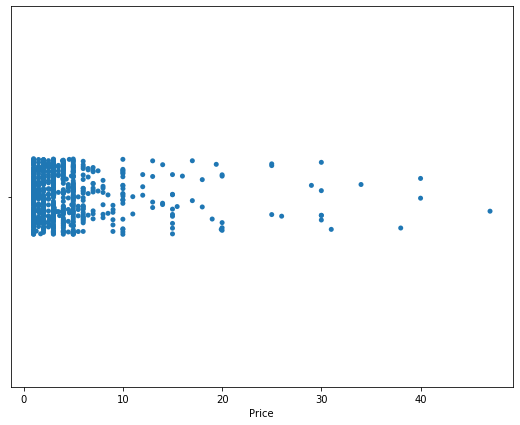

In [139]:
price0_50 = only_paid[only_paid['Price'] <= 50]
sns.stripplot(data = price0_50, x = 'Price')

From the graph, it appears that most of the apps are priced even smaller than 50 Dollars, actually 10 Dollars or less.
As before,to get a better view let us zoom in again and try to find out the distribution of apps that are priced  10 dollars or less 

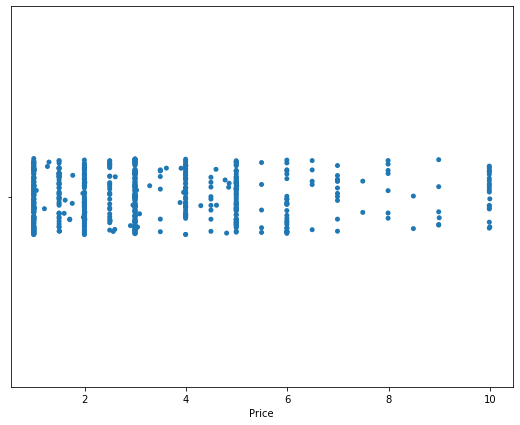

In [140]:
price0_10 = only_paid[only_paid['Price'] <= 10]
sns.stripplot(data = price0_10, x = 'Price')

From the above Graph, it is obvious that there are clusters of data at some particular prices. Lets try to find out the point where the prices are clustered.
For that purpose, let us treat the "Price" column as a discrete variable and find out the counts for each price value

In [141]:
price0_50 = only_paid[only_paid['Price'] <= 50]
price0_50['Price'].value_counts()

0.99     145
2.99     124
1.99      73
4.99      70
3.99      58
        ... 
15.99      1
19.40      1
3.95       1
19.90      1
9.00       1
Name: Price, Length: 79, dtype: int64

We see that there is a tendency among the app developers to price their apps at *.99 value. So, for drawing the frequency distribution, we have to make sure that these values fall within a particular interval ( and not as end points) to avoid ambiguity.
Also as is evident from the quartiles data and the graphs above, most apps are priced within 10 Dollars.(75% of the paid apps are priced below 5 Dollars and also among those apps that are priced above 5 Dollars, 50% of the apps are priced below 10 Dollars). So Let us draw the frequency distribution within the interval of 0-10 Dollars and the last class will be an open ended class which will take care of all apps priced above 10 Dollars.

The following code prepares the frequency distribution as above.

In [142]:
only_paid.loc[(only_paid['Price'] > 0) & (only_paid['Price'] <= 2), 'Range_of_Price']   = 'Between 0 to 2'
only_paid.loc[(only_paid['Price'] > 2) & (only_paid['Price'] <= 4), 'Range_of_Price']   = 'Between 2 to 4'
only_paid.loc[(only_paid['Price'] > 4) & (only_paid['Price'] <= 6), 'Range_of_Price']   = 'Between 4 to 6'
only_paid.loc[(only_paid['Price'] > 6) & (only_paid['Price'] <= 8), 'Range_of_Price']   = 'Between 6 to 8'
only_paid.loc[(only_paid['Price'] > 8) & (only_paid['Price'] <= 10), 'Range_of_Price']   = 'Between 8 to 10'
only_paid.loc[(only_paid['Price'] > 10), 'Range_of_Price']   = 'Above 10'



Now, let us find out the counts of apps within each price range

In [143]:
only_paid.groupby("Range_of_Price")['App'].count()

Range_of_Price
Above 10            74
Between 0 to 2     283
Between 2 to 4     228
Between 4 to 6     119
Between 6 to 8      25
Between 8 to 10     29
Name: App, dtype: int64

In the next code, we calculate the "Revenue" generated by each range of Paid Apps.
For that purpose first we use the following code to find out the Number of installs of app within each of the price ranges.

In [144]:
only_paid.groupby("Range_of_Price")['Installs'].sum().sort_values(ascending = False)


Range_of_Price
Between 0 to 2     23727983.0
Between 2 to 4     14501984.0
Between 6 to 8     11267340.0
Between 4 to 6      6694482.0
Above 10             875937.0
Between 8 to 10      798155.0
Name: Installs, dtype: float64

We observe that the number of installs are high for both the cheapest apps (that is, the apps that are priced 0 to 2 Dollars and 2 to 4 Dollars).
As expected, the apps which are highly priced have less installs.

Now, finally,we calculate the Total Revenue Generated by the Apps at each price Range.
This might help the App Developer decide on the Price Range that will bring maximum profit.

In [145]:
only_paid['Revenue'] = only_paid['Installs']*only_paid['Price']

In [146]:
only_paid.groupby("Range_of_Price")['Revenue'].sum().sort_values(ascending = False)


Range_of_Price
Above 10           98166881.63
Between 6 to 8     78891736.60
Between 2 to 4     44796011.86
Between 4 to 6     35963744.28
Between 0 to 2     27659949.97
Between 8 to 10     7671123.45
Name: Revenue, dtype: float64

The comparatively less priced apps (between 2-4 Dollars and 0-2 Dollars) inspite of having very high installs doesnt contribute to higher revenue with repect to the apps of other price brackets.

From the app developer's point of interest, it can be said that they prefer to develop the lower priced apps more (530 of 758 paid apps fall under 6 Dollars),with only few selecting the higher priced ranges.

In general, people also tend to download the cheaper apps more but when it comes to revenue  generation, the highly priced apps, inspite of having less installs, has the highest revenue and this might be attributed to  their high average price with respect to the rest. They are followed by other expensive  apps (apps which are priced between 6 Dollars and 8 Dollars) , which again had medium installs but due to high price, the revenue generation from this app segment is quite high. The app segment which are priced between 8 - 10 Dollars had only 29 Apps, causing lowest installs and correspondingly lowest revenue generation.

So, it can be said that if a proper quality app is developed at a higher priced range, though expectedly, the number of installs of the same will be less, but revenue generation might still be high.The medium priced apps are both less installed and less revenue is generated, so the app developer might choose this segement with caution.